# Impact of estimators

This notebook shows how to use the `corsort` package to compare natural estimators (if they exists) and the external estimators $\Delta$ and $\rho$.

Here the following sorts will be compared:

- Top-down merge
- Binary insertion
- Ford-Johnson
- Quicksort
- Bottom-up merge
- Multizip

The take-away is that, at least for the sort with a good performance profile, $\rho$ is usually a better estimator than $\Delta$.

First we load some packages.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from multiprocess.pool import Pool
import dill as pickle
from pathlib import Path

from corsort import *

We write a script that does the computation and display.

In [2]:
def rho_delta(MySort, leg, n, nt, natural=True):
    name = MySort().__name__
    sort_list = [MySort(compute_history=True),
    WrapSortScorer(sort=MySort(), scorer=jit_scorer_delta, compute_history=True),
    WrapSortScorer(sort=MySort(), scorer=jit_scorer_rho, compute_history=True)]
    color_dict = auto_colors(sort_list)
    legends = {name: leg,
               f"{name}_delta": f"{leg} $\\Delta$",
               f"{name}_rho": f"{leg} $\\rho$"}
    if not natural:
        sort_list = sort_list[1:]
        legends.pop(name)
    fn = Path(f"rho_delta_{name}_n_{n}_nt_{nt}.pkl")
    if fn.exists():
        with open(fn, 'rb') as f:
            convergence = pickle.load(f)
    else:
        with Pool() as p:
            convergence = evaluate_convergence(sort_list=sort_list, n=n, nt=nt, pool=p)
        with open(fn, 'wb') as f:
            pickle.dump(convergence, f)
    m = n*(n-1)/2
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes()
    decim=5

    for name in legends:
        ref = convergence[name]
        color = color_dict[name]
        p_m = ref.shape[1]
        x = np.arange(p_m)[::decim]
        ref = ref[:, ::decim]
        q = np.zeros((5, ref.shape[1]))
        for i, per in enumerate([2.5, 50, 97.5]):
            q[i, :] = np.percentile(ref, per, axis=0)
        q = q/m
        ax.plot(x, q[1, :], label=legends[name], color=color)
        ax.fill_between(x, q[0, :], q[2, :], alpha=.2, color=color)
    plt.legend()
    plt.grid()
    ax.tick_params(labelright=True, right=True)
    plt.ylabel('Distance to sorted list')
    plt.xlabel('Comparisons performed')
    plt.ylim([0, None])
    plt.xlim([0, None])
    plt.show()    

In [3]:
n=500
nt=10000

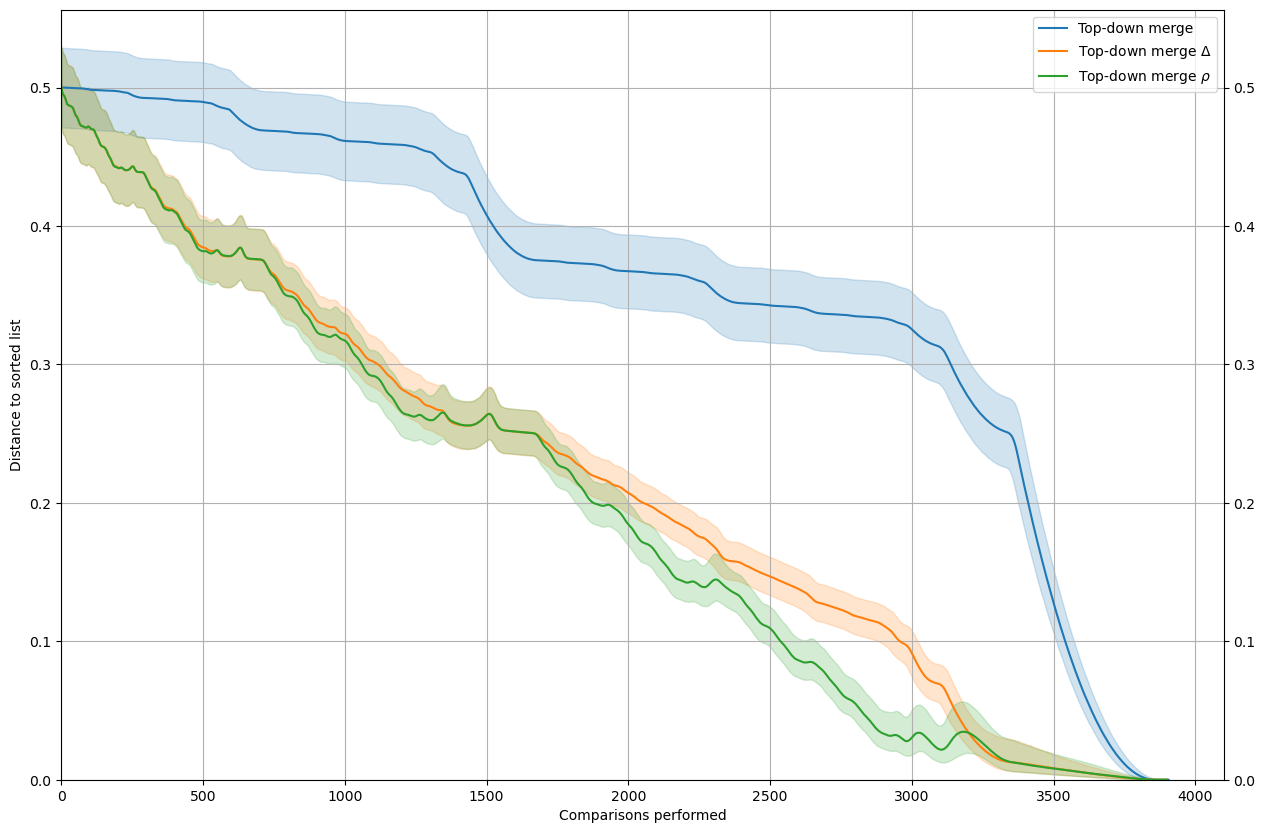

In [4]:
rho_delta(MySort=SortMergeTopDown, leg="Top-down merge", n=n, nt=nt)

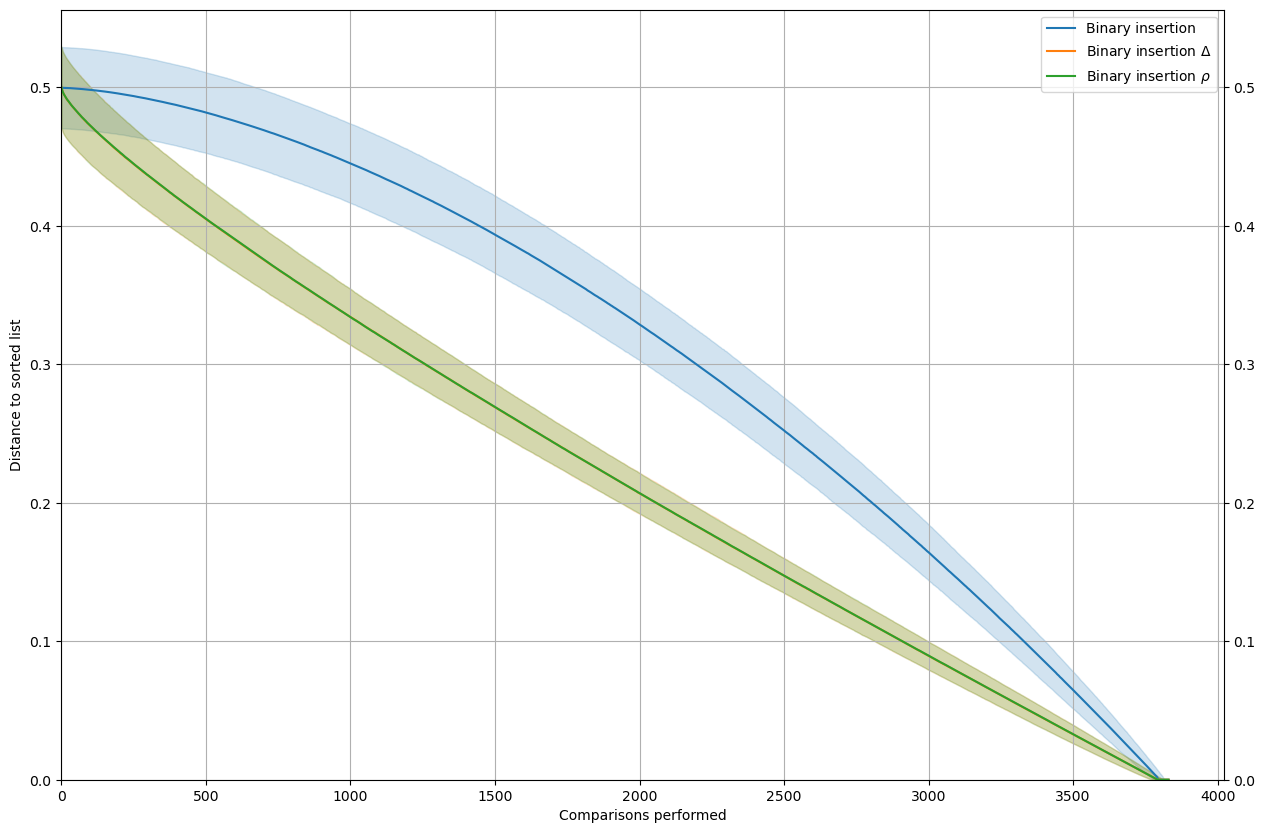

In [5]:
rho_delta(MySort=SortBinaryInsertion, leg="Binary insertion", n=n, nt=nt)

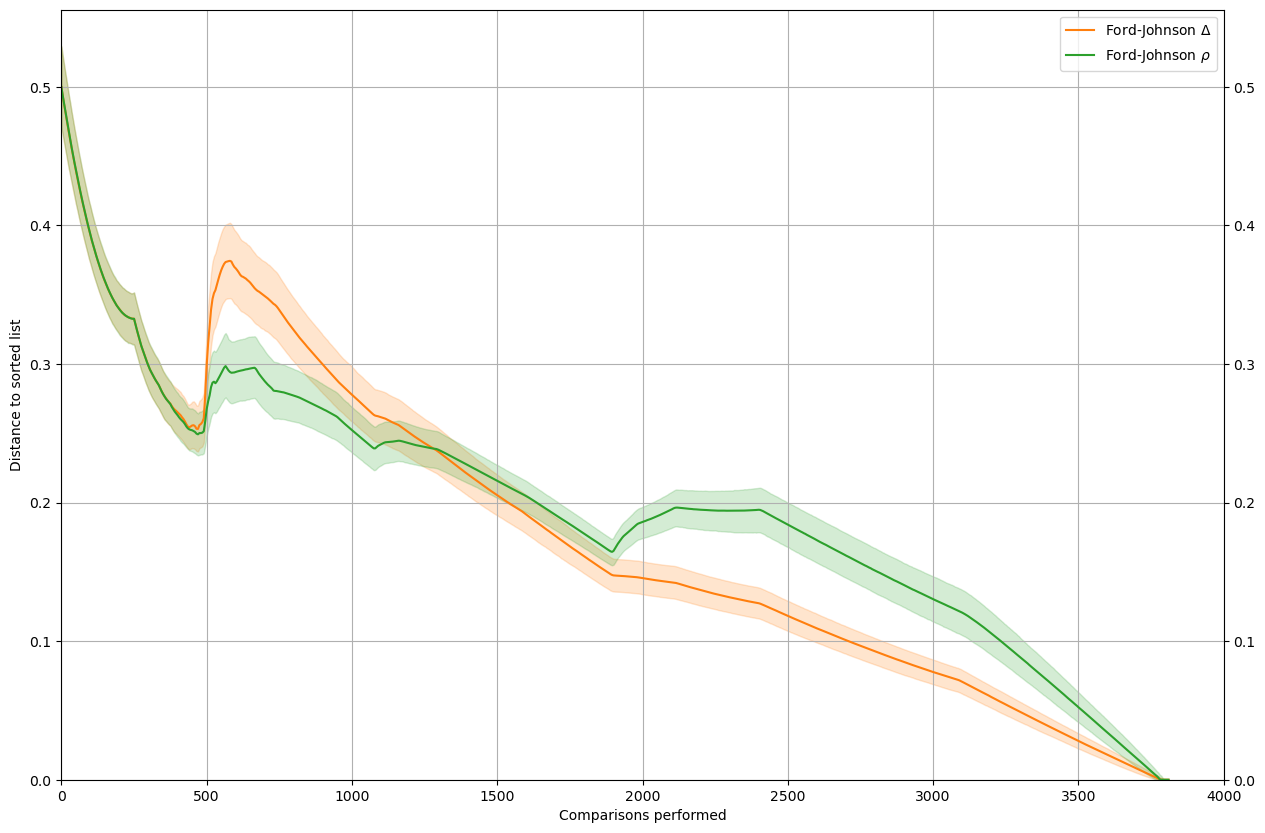

In [6]:
rho_delta(MySort=SortFordJohnson, leg="Ford-Johnson", n=n, nt=nt, natural=False)

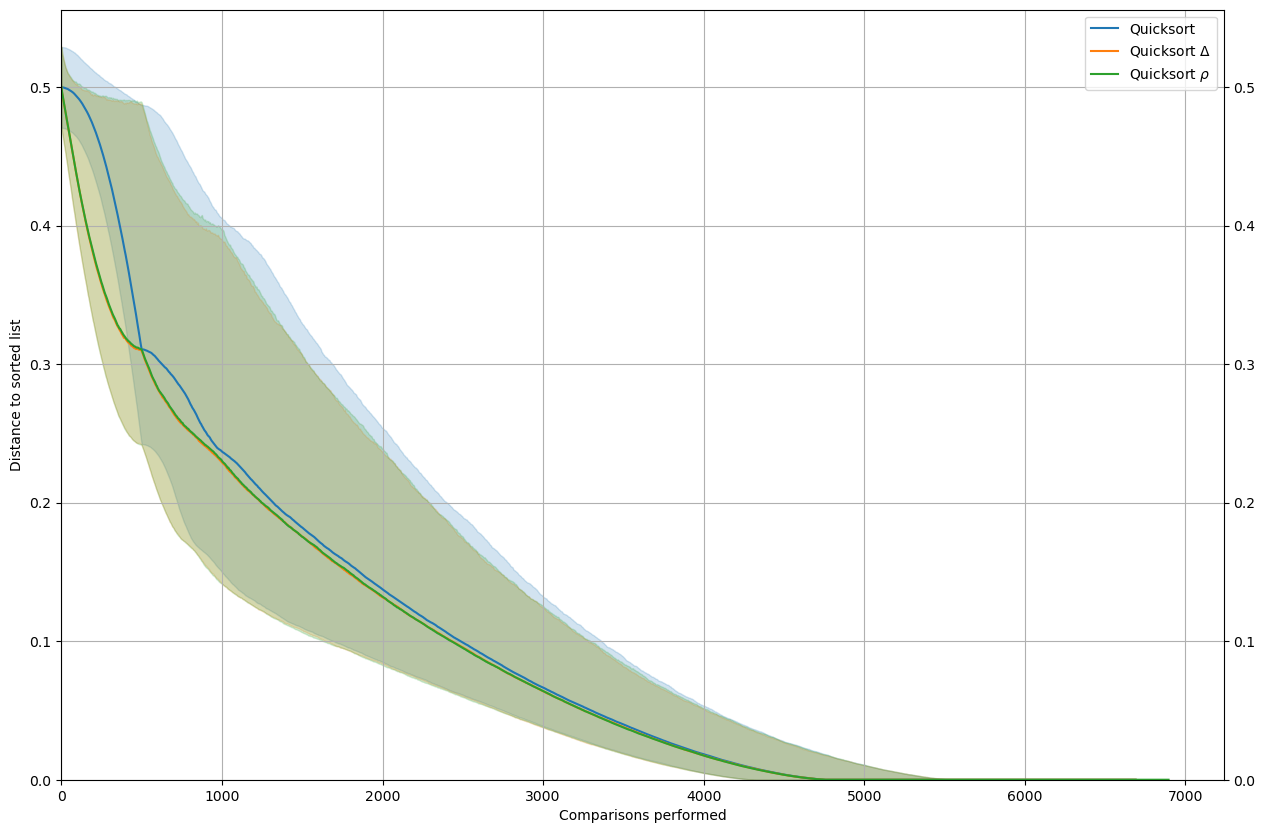

In [7]:
rho_delta(MySort=SortQuick, leg="Quicksort", n=n, nt=nt)

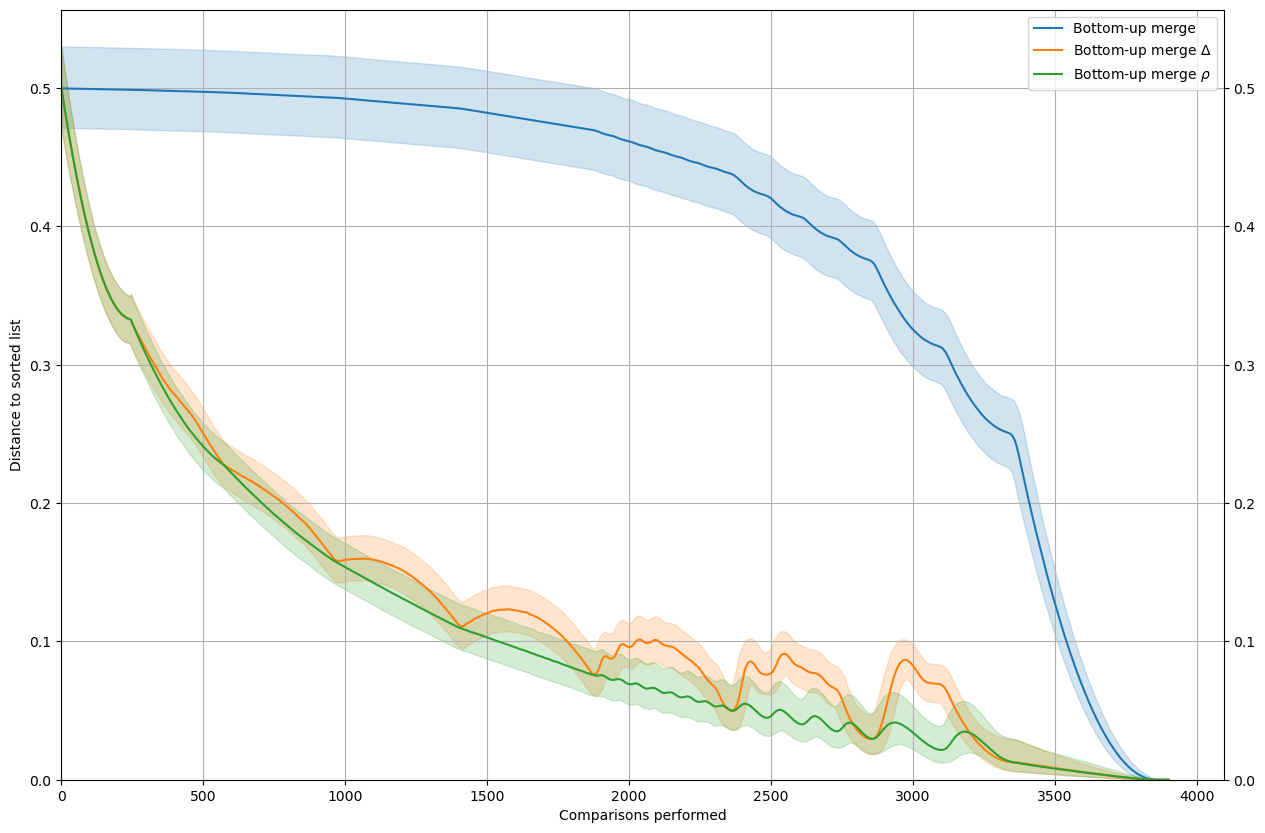

In [8]:
rho_delta(MySort=SortMergeBottomUp, leg="Bottom-up merge", n=n, nt=nt)

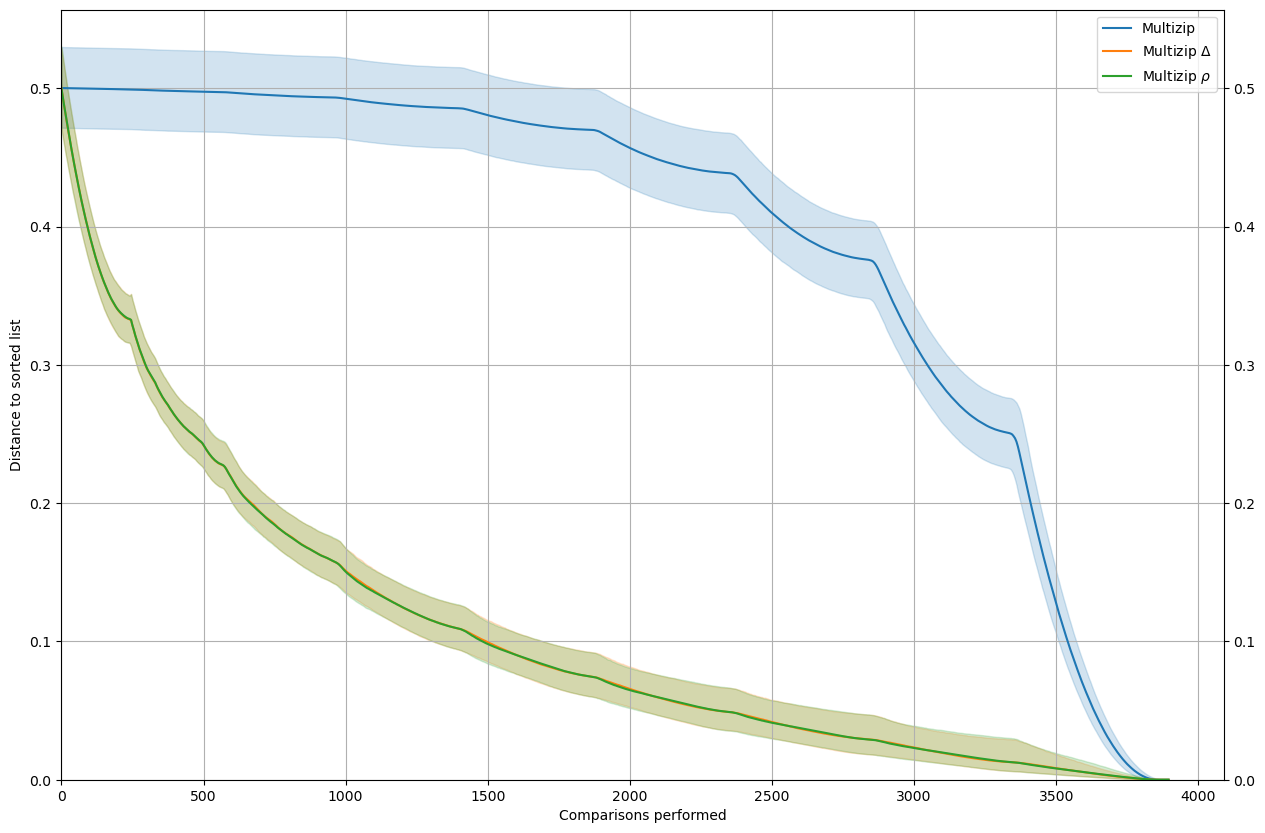

In [9]:
rho_delta(MySort=SortMultizip, leg="Multizip", n=n, nt=nt)